# Spoiler reviews-Text processing and text feature importance

__Author: Gregor Habeck with contributions from Julia Schaefer__

In [1]:
import time
from tqdm import tqdm
import json
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import swifter

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file = 'training_set.json'

In [3]:
# to import the full training dataset
t0 = time.time()
df_train = pd.read_json('training_set.json', orient = 'index')
elapsed_time = time.time()-t0
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:03:54


In [5]:
df_train.columns

Index(['average_rating', 'best_genre', 'book_id', 'description', 'genres',
       'has_spoiler', 'num_pages', 'publication_day', 'publication_month',
       'publication_year', 'rating', 'ratings_count', 'review_id',
       'review_sentences', 'timestamp', 'title', 'user_id',
       'weighted_average_rating'],
      dtype='object')

In [6]:
df_train_text = df_train.drop(['average_rating', 'best_genre','description', 'genres',
                               'num_pages', 'publication_day', 'publication_month',
                               'publication_year', 'rating', 'ratings_count', 'review_id',
                               'timestamp', 'title', 'user_id','weighted_average_rating'
                              ],
                             axis = 1)

In [7]:
df_train_text.head()

,book_id,has_spoiler,review_sentences
147051,11735983,0,"[[0, Read this review on my blog!], [0, http:/..."
1322675,18803672,0,"[[0, I was writing a comment that I realized w..."
1221889,342667,0,"[[0, Charlie is turning 30 and her younger sis..."
1008531,30422494,0,"[[0, 3.5 is more like it even though this has ..."
859048,13517455,1,"[[0, Review originally posted at Step Into Fic..."


In [9]:
# functions to isolate labels and text from review_sentences column
def get_sentence_label(x):
    return [label for label, text in x]
def get_sentence_text(x):
    return [text for label, text in x]


In [131]:
#df_train_text['sentence_labels'] = df_train_text.review_sentences.swifter.apply(lambda x:get_sentence_label(x))
df_train_text['sentence_text'] = df_train_text.review_sentences.swifter.apply(lambda x:get_sentence_text(x))

In [132]:
df_train_text.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked,sentence_text
147051,11735983,0,"[[0, Read this review on my blog!], [0, http:/...","[read this review on my blog, , definitely bet...","[Read this review on my blog!, http://roseshad..."
1322675,18803672,0,"[[0, I was writing a comment that I realized w...",[i was writing a comment that i realized would...,[I was writing a comment that I realized would...
1221889,342667,0,"[[0, Charlie is turning 30 and her younger sis...",[charlie is turning and her younger sister is ...,[Charlie is turning 30 and her younger sister ...
1008531,30422494,0,"[[0, 3.5 is more like it even though this has ...",[is more like it even though this has got to b...,[3.5 is more like it even though this has got ...
859048,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...,[Review originally posted at Step Into Fiction...


In [26]:
df_train_text = df_train_text.drop(['sentence_labels'], axis = 1)

In [134]:
#confirm that reviwes are written in english:
!pip install langdetect
from langdetect import detect, DetectorFactory

DetectorFactory.seed = 42

def detect_review_language(text):
    try:
        text = ' '.join(text)
        return detect(text)
    except:
        return None

!pip install textblob
from textblob import TextBlob


In [135]:
df_train_text['review_language_1'] = df_train_text['sentence_text'].swifter.apply(lambda x:detect_review_language(x))
#df_train_text['review_language_2'] = df_train_text['sentence_text'].swifter.apply(lambda x:textblob_detection(x))


In [14]:
df_train_text.review_language_1.unique()

array(['en', 'nl', 'it', 'cy', 'af', 'de', 'ro', 'sw', 'sl', 'so', 'fr',
       'no', 'tl', 'et', 'sv', 'es', 'da', 'pl', 'ca', 'hr', 'sk', 'id',
       'pt', 'fi', 'vi', 'cs', 'hu', 'tr', 'sq', 'lt'], dtype=object)

In [136]:
def detect_review_language_start(text):
    try:
        text = ' '.join(text[:3])
        return detect(text)
    except:
        return None
    
df_train_text['review_language_start'] = df_train_text['sentence_text'].swifter.apply(lambda x:detect_review_language_start(x))


In [164]:
lang_all

(array(['af', 'ca', 'cs', 'cy', 'da', 'de', 'en', 'es', 'et', 'fi', 'fr',
        'hr', 'hu', 'id', 'it', 'lt', 'nl', 'no', 'pl', 'pt', 'ro', 'sk',
        'sl', 'so', 'sq', 'sv', 'sw', 'tl', 'tr', 'vi'], dtype=object),
 array([   165,     15,      4,     47,     51,     80, 963648,     27,
            31,      7,     52,      5,      5,     26,     85,      2,
            69,     59,     13,     12,     45,      7,     11,     43,
             8,     34,      7,     49,      4,     12]))

In [165]:
lang_start

(array(['af', 'ca', 'cs', 'cy', 'da', 'de', 'en', 'es', 'et', 'fi', 'fr',
        'hr', 'hu', 'id', 'it', 'lt', 'lv', 'nl', 'no', 'pl', 'pt', 'ro',
        'sk', 'sl', 'so', 'sq', 'sv', 'sw', 'tl', 'tr', 'vi'], dtype=object),
 array([   444,     74,     11,    400,    132,    915, 959708,    127,
            78,     15,    231,     32,     33,    130,    193,      5,
             2,    214,    430,    285,    133,    114,     18,     71,
           262,     19,    207,     36,    186,     37,     81]))

In [175]:
language_dict = {'af': 'Afrikaans',
                 'ca': 'Catalan',
                 'cs': 'Czech',
                 'cy': 'Welsh',
                 'da': 'Danish',
                 'de': 'German',
                 'en': 'English',
                 'es': 'Spanish',
                 'et': 'Estonina',
                 'fi': 'Finnish',
                 'fr': 'French',
                 'hr': 'Croation',
                 'hu': 'Hungarian',
                 'id': 'Indonesian',
                 'it': 'Italian',
                 'lt': 'Lithuanina',
                 'lv': 'Latvian',
                 'nl': 'Dutch',
                 'no': 'Norwegian',
                 'pl': 'Polish',
                 'pt': 'Portuguese',
                 'ro': 'Romanina',
                 'sk': 'Slovak',
                 'sl': 'Slovenian',
                 'so': 'Somali',
                 'sq': 'Albanian',
                 'sv': 'Swedish',
                 'sw': 'Swahili',
                 'tl': 'Tagalog',
                 'tr': 'Turkish',
                 'vi': 'Vietnamese'
                 }

In [305]:
lang_all = np.unique(df_train_text['review_language_1'], return_counts=True)
lang_all_country = [language_dict[abreviation] for abreviation in list(lang_all[0])]
lang_start_country = [language_dict[abreviation] for abreviation in list(lang_start[0])]

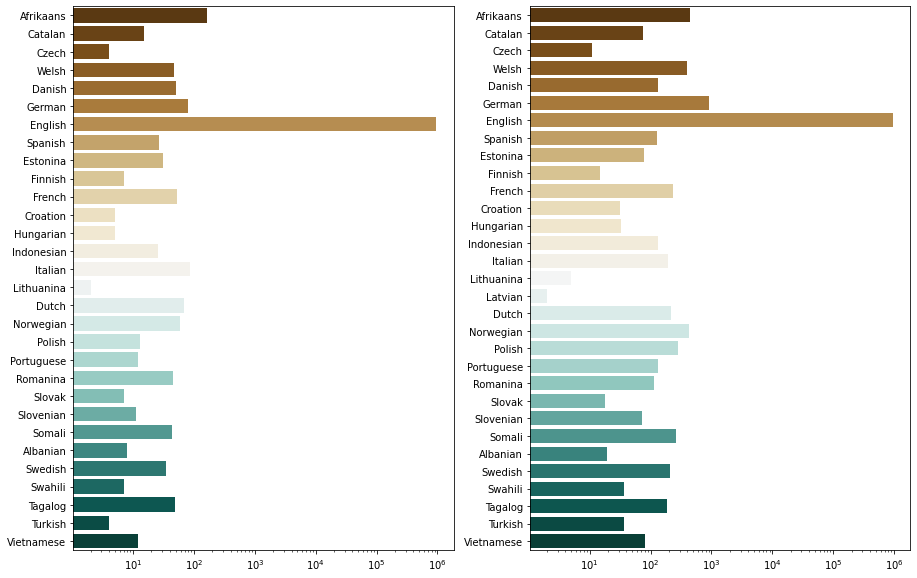

In [306]:
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(15,10))
sns.barplot(ax = ax1, x=lang_all[1], y=lang_all_country, palette = 'BrBG' )
ax1.set_xscale('log')
sns.barplot(ax = ax2, x=lang_start[1], y=lang_start_country, palette = 'BrBG' )
ax2.set_xscale('log')


Text(0, 0.5, '% of reviews (log)')

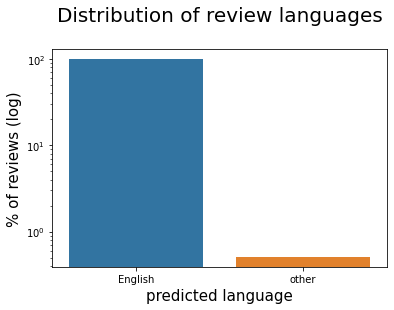

In [394]:
sum_all = np.sum(lang_start[1])
english = np.max(lang_start[1])
rest = sum_all-english
labels = ['English', 'other']
values = [english/sum_all*100, rest*100/sum_all]
ax = sns.barplot(x = labels, y = values)
ax.set_yscale('log')
ax.set_title('Distribution of review languages\n', fontsize = 20)
ax.set_xlabel('predicted language', fontsize = 15)
ax.set_ylabel( '% of reviews (log)', fontsize = 15)

In [375]:
df_train_text_es = df_train_text[df_train_text['review_language_1'] == 'es']
df_train_text_es

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked,sentence_text,review_language_1,review_language_start,spoiler_in_text,lan_unclear
77919,7260188,0,"[[0, ** spoiler alert **], [0, Bueno fue un fi...","[spoiler alert, bueno fun un final de die to a...","[** spoiler alert **, Bueno fue un final de ci...",es,es,1,False
1046929,10380227,0,"[[0, Awsome!!!], [0, i really relly love it!!]...","[awesome, i really reply love it, seht is so k...","[Awsome!!!, i really relly love it!!, Seht is ...",es,en,0,True
847263,23688792,0,"[[0, Fun train read!]]",[fun train read],[Fun train read!],es,es,0,False
1336307,53447,1,"[[0, For practice I decided that I'd write thi...",[for practice i decided that i would write thi...,[For practice I decided that I'd write this re...,es,en,1,True
1196218,22929092,0,"[[0, Can I have a sequel please?]]",[can i have a sequel please],[Can I have a sequel please?],es,es,0,False
596079,19358975,0,"[[0, Gracias Patrick Rothfuss por tu recomenda...",[garcias patrick rothfuss for tu recommend act...,[Gracias Patrick Rothfuss por tu recomendacion...,es,es,0,False
231317,930,0,"[[0, An enjoyable enough read.]]",[an enjoyable enough read],[An enjoyable enough read.],es,es,0,False
621343,26148181,0,"[[0, And then we end--we end where we started....","[and then we end we end where we started, just...","[And then we end--we end where we started., Ju...",es,en,0,True
209767,18459855,0,"[[0, A sequel?], [0, Interesting...]]","[a sequel, interesting]","[A sequel?, Interesting...]",es,es,0,False
944602,23012475,0,"[[0, Perfectly enjoyable, very quick read.]]",[perfectly enjoyable very quick read],"[Perfectly enjoyable, very quick read.]",es,es,0,False


In [370]:
df_train_text_en_unclear = df_train_text[df_train_text['review_language_1'] != 'en']

In [365]:
df_train_text_en_unclear[['sentence_text_spellchecked', 'review_language_1', 'review_language_start']]

,sentence_text_spellchecked,review_language_1,review_language_start
93384,"[poor george poor lenny poor crooks, tragedy]",nl,nl
1203390,"[recension, review]",it,it
189971,"[my, heart, is, broken]",nl,en
1373142,[good cheesy scifi],cy,cy
363839,"[oh god, oh my god, god, oh, ah, i can do it i...",cy,cy
250260,"[stars, great book]",af,af
127187,"[review posted here, , german review added deb...",de,de
1053203,[a pure delight],ro,ro
1108451,"[interesting premise, active plot, men meets d...",nl,nl
492791,[mess me up],sw,sw


In [372]:
# calculate length of reviews not recognized as english
df_train_text_en_unclear['length_review'] = df_train_text_en_unclear['sentence_text_spellchecked'].swifter.apply(lambda x: len(x))

Exception ignored in: 

<bound method tqdm.__del__ of Pandas Apply: 100%|<bar/>| 975/975 [03:54<00:00,  4.17it/s]>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/nf/lib/python3.6/site-packages/tqdm/std.py", line 1086, in __del__
    def __del__(self):
KeyboardInterrupt
/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [373]:
df_train_text_en_unclear.describe()

,book_id,has_spoiler,spoiler_in_text,length_review
count,9.750000e+02,975.000000,975.000000,975.000000
mean,1.403203e+07,0.013333,0.008205,2.078974
std,9.513911e+06,0.114757,0.090256,4.026213
min,1.000000e+00,0.000000,0.000000,1.000000
25%,6.592470e+06,0.000000,0.000000,1.000000
50%,1.478088e+07,0.000000,0.000000,1.000000
75%,2.089890e+07,0.000000,0.000000,2.000000
max,3.599877e+07,1.000000,1.000000,50.000000


In [204]:
from textblob import TextBlob
b = TextBlob('This was a bad book')
b.sentiment.polarity

-0.6999999999999998

In [186]:
df_train_text_not_en.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked,sentence_text,review_language_1,review_language_start,lang_textblob
854534,15752348,1,"[[0, Okay, Ms.], [0, Verdi.], [0, You win.], [...","[okay ms, verdi, you win, this was almost four...","[Okay, Ms., Verdi., You win., This was almost ...",en,af,None
93384,890,0,"[[0, poor George, poor Lenny, poor Crooks.], [...","[poor george poor lenny poor crooks, tragedy]","[poor George, poor Lenny, poor Crooks., Tragedy.]",nl,nl,None
1118362,23599075,0,"[[0, Okay look, I get you Celaeana.], [0, You ...","[okay look i get you celaena, you like reading...","[Okay look, I get you Celaeana., You like read...",en,af,None
204587,22918050,0,"[[0, WHAT IS WRONG WITH THEIR NAMES ?], [0, Ah...","[what is wrong with their names, aren, what, i...","[WHAT IS WRONG WITH THEIR NAMES ?, Ahren ?, Wh...",en,de,None
887188,24950581,0,"[[0, AAAA!!!!], [0, Yes!], [0, Home run, Touch...","[aaa, yes, home run touch down gooooooaaaaalll...","[AAAA!!!!, Yes!, Home run, Touch down, Goooooo...",en,nl,None


In [ ]:
df_train_text_lang_identical = df_train_text[df_train_text['review_language_1'] != df_train_text[]]

In [ ]:
df_train_text_not_en.shape

In [ ]:
df_train_text_not_en[['sentence_text', 'review_language_1']]

In [ ]:
def textblob_detection(text):
    try:
        text = ' '.join(text)
        b = TextBlob(text)
        return b.detect_language()
    except:
        return None

df_train_text_not_en['textblo_lan']=df_train_text_not_en['sentence_text'].swifter.apply(lambda x:textblob_detection(x))


In [ ]:
df_train_text_not_en[['sentence_text', 'has_spoiler']]

Clearly, there are reviews not (completely) written in english. However, therer are also some reviews that are 

## Spell checking using SympSpell

In [ ]:
#install and import
!python -m pip install -U symspellpy
from symspellpy import SymSpell, Verbosity

### Build a dictionary based on the description of the books

The idea behind this custom dictionary is adding book specific words such as names to the standard english dictionary used by symspell. If even their frequency will be low it might help for spell checking.

In [13]:
#for text editing, replace contractions
#https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
def decontracted(text):
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"let\'s", "let us", text)
    

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    
    #words
    text = re.sub("gimme", "give me", text)
    text = re.sub("cuz", "because", text)
    text = re.sub("'cause", "give me", text)
    text = re.sub("finna", "fixing to", text)
    text = re.sub("cuz", "because", text)
    text = re.sub("wanna", "want to", text)
    text = re.sub("gotta", "got to", text)
    text = re.sub("hafta", "have to", text)
    text = re.sub("woulda", "would have", text)
    text = re.sub("coulda", "could have", text)
    text = re.sub("shoulda", "should have", text)
    text = re.sub("ma'am", "madam", text)
    text = re.sub("howdy", "how do you", text)
    text = re.sub("let's", "let us", text)
    text = re.sub("y'all", "you all", text)

    return text

In [29]:
import re

# function to preprocess text
def preprocessing(text):
    t0 = time.time()
    # remove '--' and replace them with whitespace
    text = text.replace('-', ' ')
    #change to lower case
    text=text.lower()
    # replace contractions
    text = decontracted(text)
    #remove urls if there are any
    text = re.sub(r'http:\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    #remove emails and words containing @
    text = re.sub("\S*@\S*\s?"," ", text)
    # remove digits and words containing digits
    text = re.sub(r"\d", "", text)
    #remove special characters and punctuation
    text = re.sub(r'[(,;:@#&$!?.)"*/-]+', ' ', text)
    text = re.sub(r"[']", '', text)
    # replace whitespaces
    text = re.sub(r"\s+", ' ', text).strip()
    return text

In [ ]:
#collect text (book descriptions and titles)
# we assume that they harly contain spelling errors as the are 
# for a test run only load the first 100,000 descriptions and titles

descriptions = ([d for d in df_train_text.description if d != None])
# also add title texts
descriptions += ([t for t in df_train_text.title if t != None])

description = pd.Series(descriptions).apply(lambda x:preprocessing(x))
description_processed = [d for d in description]

In [ ]:
# open dictionary text file and save the words in the words_dict list
import pkg_resources

dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
words_dict = []
with(open(dictionary_path, 'r')) as df:
    for line in df:
        word = line.split()[0]
        words_dict.append(word)
df.close()
words_dict = set(words_dict)

In [ ]:
print(f'The dictionary contains {len(words_dict)} different words and their frequency.')

In [ ]:
#create a frequency count list 
#only get word count of words not included in the standard english dictionary of symspell
#desc2_split = desc2.split()
wordlist = []
for d in description_processed:
    d = d.split()
    for word in d:
        if word not in words_dict and len(word)>1:
            wordlist.append(word)
        else:
            continue

In [ ]:
wordlist[:100]

While going through the wordlist we noticed that it contains french words. These words should not be included in the new dictionary. To test whether other descriptions are written in languages other than 'english', we will use langdetect.

In [ ]:
# automatically detect language of description texts
# we use try/except as description contains None
def detect_language(text):
    try:
        return detect(text[:300])
    except:
        return None

In [ ]:
df_train_text['language_description'] = df_train_text['description'].swifter.apply(lambda x: detect_language(x))

In [ ]:
# safe df_train_text
df_train_text.to_json('df_train_text.json', orient = 'records')

In [ ]:
#!pip install langdetect
#from langdetect import detect

# get descriptions only, no titles (note that this is before preprocessing)
#languages = [detect(d[:300]) for d in (descriptions)]

In [ ]:
languages_desc = df_train_text['language_description']
print(languages_desc.shape)
print(f'{round(languages_desc.isnull().sum()/languages_desc.shape[0],2)*100}% of descriptions are missing')
languages_desc.fillna('missing', inplace = True)

languages_count=np.unique(languages_desc, return_counts=True)
languages_count

In [ ]:
fig = sns.barplot(y = languages_count[0], x = np.log(languages_count[1]), palette= 'BrBG' )
fig.set(xlabel = 'log(language count)', ylabel = 'languages', title = 'Language of book descriptions')

In [ ]:
# number of non-english book descriptions:
print('The predominant language of the book descriptions is english.')
print(f'There are {np.sum(languages_count[1])- np.amax(languages_count[1])} books with non-english or missing descriptions.')

In [ ]:
# write english descriptions into one list and all other descriptions in another list
descriptions_en = []
description_other =[]
for des,leng in description_language:
    if leng == 'en':
        descriptions_en.append(des)
    else:
        description_other.append((des,leng))

In [ ]:
#somehow the len() function does not work, use a loop to count items
i = 0
for d in descriptions_en:
    i += 1
print(f'There are {i} english book descriptions')

In [ ]:
# repeat processing with english descriptions only
description_en_processed = [preprocessing(d) for d in descriptions_en]

In [ ]:
#write all words not yet in the standard dictionary to a new list
wordlist_en = []
for d in description_en_processed:
    d = d.split()
    for word in d:
        if word not in words_dict and len(word)>1:
            wordlist_en.append(word)
        else:
            continue

In [ ]:
#count words
wordlist_en_freq = Counter(wordlist_en)

In [ ]:
# look at the first 10 
i = 0
for w, c in wordlist_en_freq.items():
    print(w, c)
    i += 1
    if i == 10:
        break

In [ ]:
import os
from shutil import copyfile
# copy default dictionary file to working directory and rename
curent_path = os.getcwd()
copyfile(dictionary_path, str(curent_path) + '/custom_dictionary.txt')

In [ ]:
# add custom frequency list to dictionary
with open('custom_dictionary.txt', 'a') as cd:
    for w, c in wordlist_en_freq.items():
        cd.write(f'{w} {c}\n')
cd.close()

In [ ]:
from symspellpy import SymSpell, Verbosity

#initiatae SmSpell with the custom  dictionary
custom_dictionary_path = os.path.abspath("custom_dictionary.txt") 
symspell = SymSpell()
#load dictionary
symspell.load_dictionary(custom_dictionary_path, term_index=0, count_index=1)

def spellcheck(text):
    '''
    function takes string as input, preprocesses text and returns a spellchecked text
    '''
    
    #preprocess text
    text = preprocessing(text)
    #hand to spellchecking and return the best result only if corrected phrase is more than just a single letter
    # otherwise continue
    sp = symspell.lookup_compound(text, max_edit_distance=1)
    if sp[0].term == None:
        return text
    else:
        return sp[0].term

In [30]:
import os
from symspellpy import SymSpell, Verbosity

custom_dictionary_path = os.path.abspath("custom_dictionary.txt") 
symspell = SymSpell()
#load dictionary
symspell.load_dictionary(custom_dictionary_path, term_index=0, count_index=1)

def spellcheck_list(text):
    '''
    function takes list of strings as input, preprocesses text and returns a spellchecked text
    '''
    
    #initiatae SmSpell with the custom  dictionary
    
    store = []
    for l,s in text:
    #preprocess text
        s = preprocessing(s)
    #hand to spellchecking and return the best result only if corrected phrase is more than just a single letter
    # otherwise continue
        sp = symspell.lookup_compound(s, max_edit_distance=1)
        if sp[0].term == None:
            store.append(s)
        else:
            store.append(sp[0].term)
    return store

In [138]:
df_train_text.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked,sentence_text,review_language_1,review_language_start
147051,11735983,0,"[[0, Read this review on my blog!], [0, http:/...","[read this review on my blog, , definitely bet...","[Read this review on my blog!, http://roseshad...",en,en
1322675,18803672,0,"[[0, I was writing a comment that I realized w...",[i was writing a comment that i realized would...,[I was writing a comment that I realized would...,en,en
1221889,342667,0,"[[0, Charlie is turning 30 and her younger sis...",[charlie is turning and her younger sister is ...,[Charlie is turning 30 and her younger sister ...,en,en
1008531,30422494,0,"[[0, 3.5 is more like it even though this has ...",[is more like it even though this has got to b...,[3.5 is more like it even though this has got ...,en,en
859048,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...,[Review originally posted at Step Into Fiction...,en,en


In [32]:
df_train_text['sentence_text_spellchecked'] = df_train_text['review_sentences'].swifter.apply(lambda x:spellcheck_list(x))


In [36]:
df_train_text.to_json('train_set_text_spellcheck.json', orient = 'records', lines = True, compression = 'gzip'  )

In [237]:
def find_spoiler(text_list):
    for sentence in text_list:
        if 'spoiler' in sentence:
            return 1
    
    return 0

In [244]:
df_train_text['spoiler_in_text']=df_train_text['sentence_text'].swifter.apply(lambda x: find_spoiler(x))

In [249]:
a = df_train_text.groupby('has_spoiler')['spoiler_in_text'].mean()

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, '"spoiler" in Review\n')

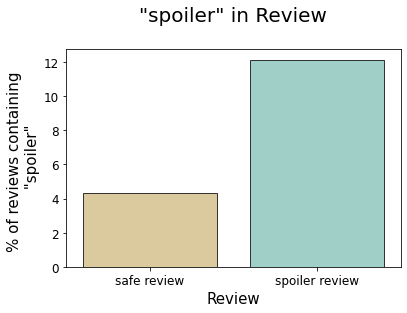

In [302]:
ax = sns.barplot(x = a.index, y = a.values*100, palette = 'BrBG', edgecolor = '0.2')
ax.set_xticklabels(['safe review', 'spoiler review'], fontsize = 12)
ax.set_yticklabels( [0,2,4,6,8,10,12],fontsize = 12)

ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = '% of reviews containing \n "spoiler"', fontsize = 15)
ax.axes.set_title('"spoiler" in Review\n', fontsize = 20)

#, ['safe review', 'spoiler review'])

In [70]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

def ned(text):
    text = re.sub(r'http:\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub("\S*@\S*\s?"," ", text)
    
    doc = nlp(text)
    
    count_PERSON = 0
    count_LOC = 0
    for x in doc.ents:
        if x.label_ == 'PERSON' or x.label_ == 'ORG':
            count_PERSON +=1
        elif x.label_ == 'LOC' or x.label_ == 'GPE':
            count_LOC += 1
    return (count_PERSON, count_LOC)

In [57]:
len(df_spoiler_reviews)

62815

In [58]:
df_spoiler_reviews = df_train_text[df_train_text['has_spoiler'] == 1]
df_safe_reviews = df_train_text.sample(62815)[df_train_text['has_spoiler'] == 0][:len(df_spoiler_reviews)]

In [46]:
df_spoiler_reviews.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked
859048,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...
1079332,13620,1,"[[0, This is an interesting volume in which L ...",[this is an interesting volume in which a lear...
135626,16096824,1,"[[0, I'm actually surprised at how much I enjo...",[i am actually surprised at how much i enjoyed...
885360,658351,1,"[[0, OK, from the date and comments I've read ...",[ok from the date and comments i have read abo...
802134,25526965,1,"[[1, The best one of the three book-series - p...",[the best one of the three book series partly ...


In [50]:
df_spoiler_reviews['spoiler_sentences'] = df_spoiler_reviews['review_sentences'].swifter.apply(lambda x:get_sentence_text(x))
df_spoiler_reviews['spoiler_labels'] = df_spoiler_reviews['review_sentences'].swifter.apply(lambda x:get_sentence_label(x))


/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [52]:
df_spoiler_reviews.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked,spoiler_sentences,spoiler_labels
859048,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...,[Review originally posted at Step Into Fiction...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1079332,13620,1,"[[0, This is an interesting volume in which L ...",[this is an interesting volume in which a lear...,[This is an interesting volume in which L lear...,"[0, 1, 1, 0]"
135626,16096824,1,"[[0, I'm actually surprised at how much I enjo...",[i am actually surprised at how much i enjoyed...,[I'm actually surprised at how much I enjoyed ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
885360,658351,1,"[[0, OK, from the date and comments I've read ...",[ok from the date and comments i have read abo...,"[OK, from the date and comments I've read abou...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."
802134,25526965,1,"[[1, The best one of the three book-series - p...",[the best one of the three book series partly ...,[The best one of the three book-series - partl...,[1]


In [61]:
sentences = []
labels = []
for r in tqdm(df_spoiler_reviews.review_sentences):
    for l, sentence in r:
        labels.append(l)
        sentences.append(sentence)
for r in tqdm(df_safe_reviews.review_sentences):
    for l, sentence in r:
        labels.append(2)
        sentences.append(sentence)


100%|██████████| 62815/62815 [00:04<00:00, 13120.24it/s]

100%|██████████| 62815/62815 [00:01<00:00, 55946.60it/s]


In [213]:
df_safe_reviews.head()

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked
147051,11735983,0,"[[0, Read this review on my blog!], [0, http:/...","[read this review on my blog, , definitely bet..."
1322675,18803672,0,"[[0, I was writing a comment that I realized w...",[i was writing a comment that i realized would...
1221889,342667,0,"[[0, Charlie is turning 30 and her younger sis...",[charlie is turning and her younger sister is ...
1008531,30422494,0,"[[0, 3.5 is more like it even though this has ...",[is more like it even though this has got to b...
399220,17934530,0,"[[0, Having just recently read his more recent...",[having just recently read his more recent boo...


In [214]:
sentences_spell_checked = []

for r in tqdm(df_spoiler_reviews.sentence_text_spellchecked):
    for sentence in r:
        sentences_spell_checked.append(sentence)
for r in tqdm(df_safe_reviews.sentence_text_spellchecked):
    for sentence in r:
        sentences_spell_checked.append(sentence)

100%|██████████| 62815/62815 [00:01<00:00, 33647.42it/s]


In [64]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([1099530,  400775,  760790]))

In [65]:
df_for_ned = pd.DataFrame({
    'sentences': sentences,
    'labels' : labels
})

In [104]:
df_for_ned.head()

,sentences,labels,ned_per_loc,people,location,has_people
0,Review originally posted at Step Into Fiction,0,"(0, 0)",0,0,False
1,I want to be rebooted.,0,"(0, 0)",0,0,False
2,I'm just not sure if I want to be a lower numb...,0,"(0, 0)",0,0,False
3,I'm leaning toward a higher number just becaus...,0,"(0, 0)",0,0,False
4,The higher the number means the longer you wer...,0,"(0, 0)",0,0,False


In [74]:
df_for_ned['ned_per_loc'] = df_for_ned['sentences'].swifter.apply(lambda x: ned(x))


  0%|          | 389/2261095 [00:19<5:32:31, 113.31it/s]

In [76]:
def get_people_count(tup):
    return tup[0]
def get_loc_count(tup):
    return tup[1]

In [85]:
df_for_ned['people'] = df_for_ned['ned_per_loc'].swifter.apply(lambda x:get_people_count(x))
df_for_ned['location'] = df_for_ned['ned_per_loc'].swifter.apply(lambda x:get_loc_count(x))


In [93]:
df_for_ned['has_people'] = df_for_ned['people'].ge(1)

In [227]:
df_for_ned.groupby('labels')['has_people'].std()

labels
0    0.429304
1    0.476106
2    0.435638
Name: has_people, dtype: float64

In [291]:
b = df_for_ned.groupby('labels').has_people.mean()
b

labels
0    0.243684
1    0.347280
2    0.254602
Name: has_people, dtype: float64

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Person mentioned in Review\n')

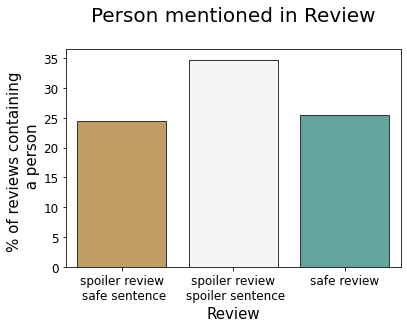

In [301]:
#fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = b.index, y = b.values*100, palette = 'BrBG', edgecolor=".2")
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
ax.set_yticklabels( [0,5,10,15,20,25,30,35],fontsize = 12)

ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = '% of reviews containing \n a person', fontsize = 15)
ax.axes.set_title('Person mentioned in Review\n', fontsize = 20)

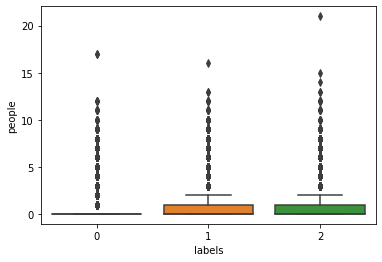

In [228]:
ax = sns.boxplot(x="labels", y="people", data=df_for_ned)


In [102]:
b =df_for_ned[df_for_ned['people']==21]

,sentences,labels,ned_per_loc,people,location,has_people
1559545,"Warren, Skye; Zaires, Anna; Winters, Pepper; R...",2,"(21, 3)",21,3,True


In [215]:
df_for_ned['sentences_spell_checked'] = pd.Series(sentences_spell_checked)

In [216]:
df_for_ned.head()

,sentences,labels,ned_per_loc,people,location,has_people,sentences_spell_checked
0,Review originally posted at Step Into Fiction,0,"(0, 0)",0,0,False,review originally posted at step into fiction
1,I want to be rebooted.,0,"(0, 0)",0,0,False,i want to be rebooted
2,I'm just not sure if I want to be a lower numb...,0,"(0, 0)",0,0,False,i am just not sure if i want to be a lower num...
3,I'm leaning toward a higher number just becaus...,0,"(0, 0)",0,0,False,i am leaning toward a higher number just becau...
4,The higher the number means the longer you wer...,0,"(0, 0)",0,0,False,the higher the number means the longer you wer...


In [315]:
def TextBlob_sentiment(text):
    tb = TextBlob(text)
    return tb.sentiment.polarity

def TextBlob_sentiment_subjectivity(text):
    tb = TextBlob(text)
    return tb.sentiment.subjectivity

In [316]:
#df_for_ned['textblob_sentiment']= df_for_ned['sentences_spell_checked'].swifter.apply(lambda x: TextBlob_sentiment(x))
df_for_ned['textblob_subjectivity']= df_for_ned['sentences_spell_checked'].swifter.apply(lambda x: TextBlob_sentiment_subjectivity(x))


In [317]:
df_for_ned.head()

,sentences,labels,ned_per_loc,people,location,has_people,sentences_spell_checked,textblob_sentiment,textblob_subjectivity
0,Review originally posted at Step Into Fiction,0,"(0, 0)",0,0,False,review originally posted at step into fiction,0.375,0.750000
1,I want to be rebooted.,0,"(0, 0)",0,0,False,i want to be rebooted,0.000,0.000000
2,I'm just not sure if I want to be a lower numb...,0,"(0, 0)",0,0,False,i am just not sure if i want to be a lower num...,0.000,0.694444
3,I'm leaning toward a higher number just becaus...,0,"(0, 0)",0,0,False,i am leaning toward a higher number just becau...,0.375,0.500000
4,The higher the number means the longer you wer...,0,"(0, 0)",0,0,False,the higher the number means the longer you wer...,0.025,0.450000


In [323]:
c = df_for_ned.groupby('labels')['textblob_sentiment'].mean()
c

labels
0    0.111143
1    0.062044
2    0.126241
Name: textblob_sentiment, dtype: float64

Text(0.5, 1.0, 'Sentiment Polarity of Review Sentences\n')

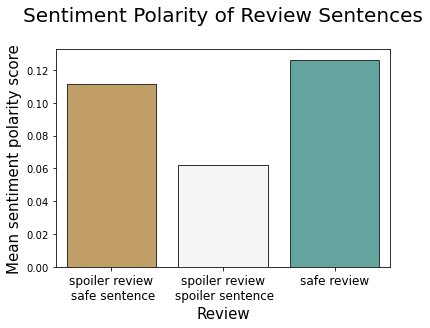

In [338]:
#fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = c.index, y = c.values, palette = 'BrBG', edgecolor=".2")
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
#ax.set_yticklabels( [0,5,10,15,20,25,30,35],fontsize = 12)
ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = 'Mean sentiment polarity score', fontsize = 15)
ax.axes.set_title('Sentiment Polarity of Review Sentences\n', fontsize = 20)

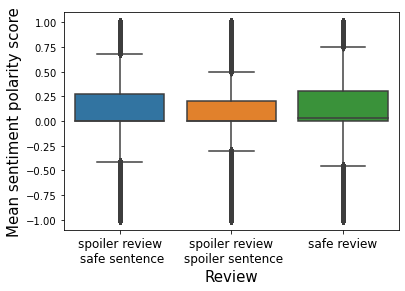

In [346]:
ax = sns.boxplot(x = 'labels', y = 'textblob_sentiment', data = df_for_ned)
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = 'Mean sentiment polarity score', fontsize = 15)
plt.show(ax)

In [333]:
d = df_for_ned.groupby('labels')['textblob_subjectivity'].mean()
d

labels
0    0.414494
1    0.389195
2    0.421280
Name: textblob_subjectivity, dtype: float64

Text(0.5, 1.0, 'Sentiment Subjectivity of Review Sentences\n')

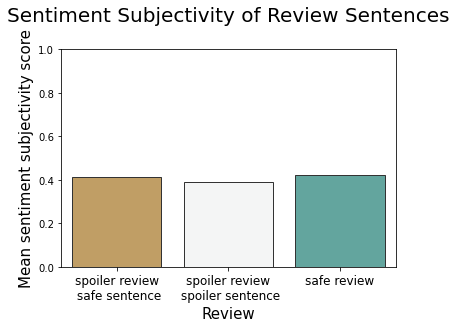

In [335]:
#fig, ax = plt.subplots(figsize = (10,5))
ax = sns.barplot(x = d.index, y = d.values, palette = 'BrBG', edgecolor=".2")
ax.set_xticklabels(['spoiler review\n safe sentence', 'spoiler review\n spoiler sentence', 'safe review'], fontsize = 12)
#ax.set_yticklabels( [0,0.20,0.40,0.60,0.80,1],fontsize = 12)
ax.set_ylim(0,1)
ax.set_xlabel(xlabel = 'Review', fontsize = 15 )
ax.set_ylabel(ylabel = 'Mean sentiment subjectivity score', fontsize = 15)
ax.axes.set_title('Sentiment Subjectivity of Review Sentences\n', fontsize = 20)

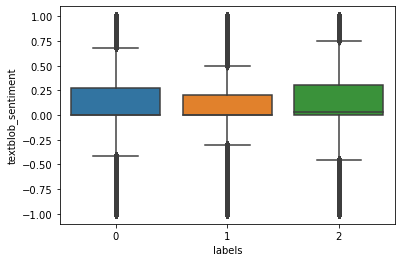

In [223]:
ax = sns.boxplot(x="labels", y="textblob_sentiment", data=df_for_ned)


In [121]:
df_spoiler_reviews.head(1)

,book_id,has_spoiler,review_sentences,sentence_text_spellchecked
859048,13517455,1,"[[0, Review originally posted at Step Into Fic...",[review originally posted at step into fiction...


In [123]:
reviews = []
labels = []

for r in df_safe_reviews.review_sentences:
    string = ''
    for label, sentence in r:
        string += sentence
    reviews.append(string)
    labels.append('safe')

for r in df_spoiler_reviews.review_sentences:
    string = ''
    for label, sentence in r:
        string += sentence
    reviews.append(string)
    labels.append('spoiler')

In [133]:
ned_reviews = [ned(rev) for rev in reviews]

(6, 1)

In [41]:
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
param_stemmer = SnowballStemmer('english')


In [ ]:
def applyStemming(text_list):
    store = []
    for sen in text_list:
        
    return [stemmer.stem(token) for token in listOfTokens]

In [37]:
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [38]:
doc = nlp("The death of Jean Harc broke my heard")

In [ ]:
print([(X.text, X.label_) for X in doc.ents])